In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
def show_matrix(M, r=2):
    M = [[str(round(j,r)) for j in i] for i in M]
    for i in M:
        print("\t".join(list(i)))
        
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [3]:
## SET THE PROBLEM
X = np.array([[1,0.2],[1.2,0.1],[1.45,0.5],[1.1,1.3],[1.4,1.5],[1.0,2.0],[0.9,1.9]]) #X1 ~ X7 
labeled_i = [0,4] ## labeled x index
yl = np.array([0,1]) #Y1 & Y5 given
#E = [(0,1),(1,2),(0,2),(2,3),(3,4),(4,5),(5,6),(3,5)]
E = [(0,1),(1,2),(0,2),(2,3),(3,4),(4,5),(5,6),(3,5),(0,6)]

## VARIABLE HELPER
yl_temp = dict(zip(labeled_i, yl))
xl = np.array([x for i,x in enumerate(X) if i in labeled_i])
xu = np.array([x for i,x in enumerate(X) if not(i in labeled_i)])

sigma = 1

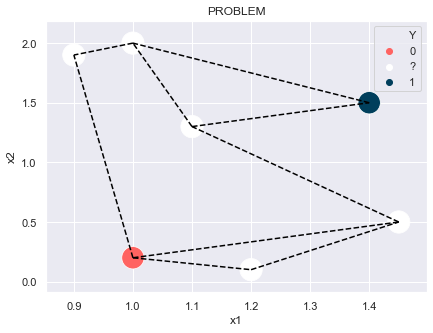

In [4]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)

# Create an array with the colors you want to use
colors = ["#ff6361", "#ffffff", "#003f5c"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

df = pd.DataFrame(X, columns=["x1","x2"])
df.loc[:, "Y"] = ["?" if i not in labeled_i else yl_temp[i] for i,x in enumerate(X)]
for e in E:
    m = np.array([X[e[0]],X[e[1]]])
    m = m.T
    ax1.plot(m[0], m[1], color='black', linestyle='dashed')
ax1 = sns.scatterplot(data=df, x="x1", y="x2", hue="Y", s=500, ax=ax1)
ax1.set_title("PROBLEM")

plt.show()

In [5]:
## Create Matrix W
def weight_func(xi, xj, sigm):
    xixj = xi - xj
    xixj2 = np.dot(xixj, xixj)
    return np.float16(np.exp(-(xixj2)/(sigm**2)))

W = []
for i,x in enumerate(X):
    w = [weight_func(X[i], X[j], sigma) if ((i,j) in E or (j,i) in E) else 0 for j in range(len(X))]
    W.append(w)
W = np.array(W)

## Matrix A' (ΔU)
A_ = []
for i,x in enumerate(X):
    a = [W[i][j] if i!=j else -np.sum(W[i]) for j in range(len(X))]
    A_.append(a)
A_ = np.array(A_)

## Matrix A
A = []
for i,x in enumerate(X):
    if i in labeled_i:
        a = [1 if j==i else 0 for j in range(len(X))]
    else:
        a = [x for x in A_[i]]
    A.append(a)
A = np.array(A)

## Create b
b = np.array([0 if i not in labeled_i else yl_temp[i] for i,x in enumerate(X)]).T

## 1) Direct Solution (inverse matrix using numpy)
$u=A^{-1}b$

In [6]:
U = np.dot(np.linalg.inv(A),b)
Y = np.array([1 if u>0.5 else 0 for u in list(U)])
print("X : ")
show_matrix(X)
print("Y : \n", Y)
print("U : \n", np.round(U,2))

X : 
1.0	0.2
1.2	0.1
1.45	0.5
1.1	1.3
1.4	1.5
1.0	2.0
0.9	1.9
Y : 
 [0 0 0 1 1 1 1]
U : 
 [0.   0.1  0.22 0.77 1.   0.85 0.81]


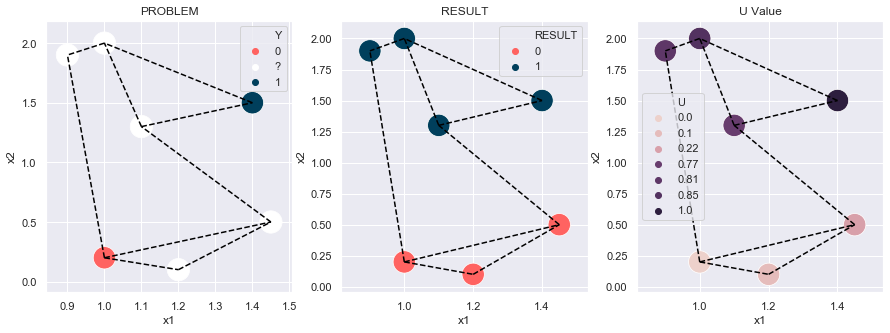

In [7]:
## PLOT THE RESULT

plt.figure(figsize=(15,5))

ax1 = plt.subplot(131)

# Create an array with the colors you want to use
colors = ["#ff6361", "#ffffff", "#003f5c"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

df = pd.DataFrame(X, columns=["x1","x2"])
df.loc[:, "Y"] = ["?" if i not in labeled_i else yl_temp[i] for i,x in enumerate(X)]
for e in E:
    m = np.array([X[e[0]],X[e[1]]])
    m = m.T
    ax1.plot(m[0], m[1], color='black', linestyle='dashed')
ax1 = sns.scatterplot(data=df, x="x1", y="x2", hue="Y", s=500, ax=ax1)
ax1.set_title("PROBLEM")

ax2 = plt.subplot(132)
# Create an array with the colors you want to use
colors = ["#ff6361", "#003f5c"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
df = pd.DataFrame(X, columns=["x1","x2"])
df.loc[:, "RESULT"] = Y
sns.scatterplot(data=df, x="x1", y="x2", hue="RESULT", s=500, ax=ax2)
for e in E:
    m = np.array([X[e[0]],X[e[1]]])
    m = m.T
    ax2.plot(m[0], m[1], color='black', linestyle='dashed')
ax2.set_title("RESULT")

ax2 = plt.subplot(133)
# Create an array with the colors you want to use
colors = ["#ff6361", "#003f5c"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
df = pd.DataFrame(X, columns=["x1","x2"])
df.loc[:, "U"] = np.round(U,2)
sns.scatterplot(data=df, x="x1", y="x2", hue="U", legend="full", s=500, ax=ax2)
for e in E:
    m = np.array([X[e[0]],X[e[1]]])
    m = m.T
    ax2.plot(m[0], m[1], color='black', linestyle='dashed')
ax2.set_title("U Value")

plt.show()

## 2) Gauss Siedel Method

In [8]:
def gs_method(A,b,x=None, max_i=1000):
    n = len(b)
    if not x:
        x = np.ones(n)
    r0 = np.dot(x,x)
    for it in range(max_i):
        for i in range(n):
            sig = 0
            for j in range(n):
                if j != i:
                    sig += A[i][j]*x[j]
            x[i] = (1/A[i][i])*(b[i] - sig)
        r1 = np.dot(x,x)
        err = abs(r0 - r1)
        r0 = r1
        if err < 1e-9:
            print("iteration ", it)
            return x
        
U = gs_method(A, b)
Y = np.array([1 if u>0.5 else 0 for u in list(U)])

iteration  31


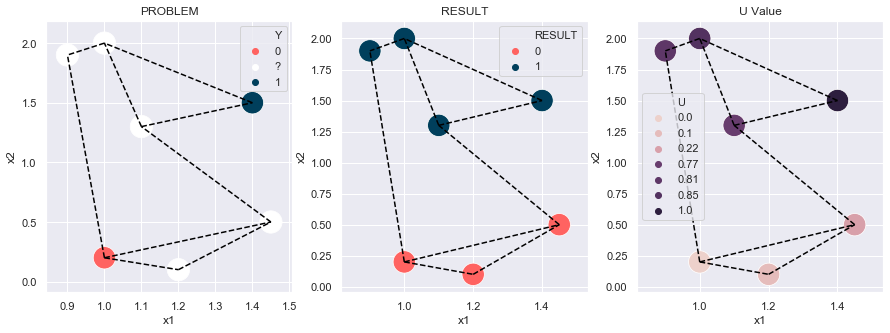

In [9]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(131)

# Create an array with the colors you want to use
colors = ["#ff6361", "#ffffff", "#003f5c"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

df = pd.DataFrame(X, columns=["x1","x2"])
df.loc[:, "Y"] = ["?" if i not in labeled_i else yl_temp[i] for i,x in enumerate(X)]
for e in E:
    m = np.array([X[e[0]],X[e[1]]])
    m = m.T
    ax1.plot(m[0], m[1], color='black', linestyle='dashed')
ax1 = sns.scatterplot(data=df, x="x1", y="x2", hue="Y", s=500, ax=ax1)
ax1.set_title("PROBLEM")

ax2 = plt.subplot(132)
# Create an array with the colors you want to use
colors = ["#ff6361", "#003f5c"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
df = pd.DataFrame(X, columns=["x1","x2"])
df.loc[:, "RESULT"] = Y
sns.scatterplot(data=df, x="x1", y="x2", hue="RESULT", s=500, ax=ax2)
for e in E:
    m = np.array([X[e[0]],X[e[1]]])
    m = m.T
    ax2.plot(m[0], m[1], color='black', linestyle='dashed')
ax2.set_title("RESULT")

ax2 = plt.subplot(133)
# Create an array with the colors you want to use
colors = ["#ff6361", "#003f5c"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
df = pd.DataFrame(X, columns=["x1","x2"])
df.loc[:, "U"] = np.round(U,2)
sns.scatterplot(data=df, x="x1", y="x2", hue="U", legend="full", s=500, ax=ax2)
for e in E:
    m = np.array([X[e[0]],X[e[1]]])
    m = m.T
    ax2.plot(m[0], m[1], color='black', linestyle='dashed')
ax2.set_title("U Value")

plt.show()

## 3) CG Method by modifying Au=b -- Fail

In [11]:
## Choose very large K
K = 1E3
g = (1/K) * b

## Create Matrix B
B = []
for i,x in enumerate(X):
    if i in labeled_i:
        a = [1 if j==i else 0 for j in range(len(X))]
    else:
        a = [0 for x in range(len(X))]
    B.append(a)
B = np.array(B) * (1/K)
print("g : ")
print(g)
print("Matrix B :")
show_matrix(B,4)

g : 
[0.    0.    0.    0.    0.001 0.    0.   ]
Matrix B :
0.001	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.001	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0


In [12]:
def conjugate_grad(A, b, x=None):
    n = len(b)
    if not x:
        x = np.ones(n)
    r = b - np.dot(A, x)
    p = r
    rsold = np.dot(r, r)
    for i in range(n):
        Ap = np.dot(A, p)
        alpha = rsold / np.dot(p.T, Ap)
        x += alpha * p
        r -= alpha * Ap
        rsnew = np.dot(r, r)
        if np.sqrt(rsnew) < 1e-10:
            print('Itr:', i)
            break
        p = (rsnew / rsold) * p + r
    return x

U = conjugate_grad(B, g)
Y = np.array([1 if u>0.5 else 0 for u in list(U)])
print("X : ", X)
print("Y : ", Y)
print("U : ", U)

Itr: 0
X :  [[1.   0.2 ]
 [1.2  0.1 ]
 [1.45 0.5 ]
 [1.1  1.3 ]
 [1.4  1.5 ]
 [1.   2.  ]
 [0.9  1.9 ]]
Y :  [0 1 1 1 1 1 1]
U :  [1.11022302e-16 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00]


In [13]:
np.linalg.inv(B)

LinAlgError: Singular matrix

In [15]:
np.linalg.det(B)

0.0